In [1]:
## Imports

# We'll need numpy for some mathematical operations
import numpy as np
import math

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

import glob
import os

from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

import random

# Import local modules
from helpers import *

In [2]:
## Load all sample files
filedir = "/Volumes/External Storage/Thesis/Corpus/eng-balm-emmanuel/flac" #"../testSounds"   # 
segment_length = 0.2  # length of segments in seconds

sounds, samplerates = load_sounds(filedir)
spectrograms, mfccs, rmss, centroids, max_num_segs = analyze_sounds(sounds, samplerates, segment_length)

num_files = len(sounds)

directory = '/Users/aaronkarp/Documents/Thesis/Code/savedData/'
to_save = [['samplerates', samplerates], ['spectrograms', spectrograms], ['mfccs', mfccs], ['rmss', rmss], ['centroids', centroids]]
save_data(to_save, directory)

Loading...
1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     23%     24%     25%     26%     27%     28%     29%     30%     31%     32%     33%     34%     35%     36%     37%     38%     39%     40%     41%     42%     43%     44%     45%     46%     47%     48%     49%     50%     51%     52%     53%     54%     55%     56%     57%     58%     59%     60%     61%     62%     63%     64%     65%     66%     67%     68%     69%     70%     71%     72%     73%     74%     75%     76%     77%     78%     79%     80%     81%     82%     83%     84%     85%     86%     87%     88%     89%     90%     91%     92%     93%     94%     95%     96%     97%     98%     99%     100%     Finished Loading
Analyzing...
1%     2%     3%     4%     5%     6%     7%     8%     9%     10%     11%     12%     13%     14%     15%     16%     17%     18%     19%     20%     21%     22%     

In [3]:
## Organize features into lists of segments
# feature1 = [segment1 segment2 segment3]
# segment1 = nxm np.matrix 

spectrograms_by_seg, spectrograms_by_seg_flat = segment_matrix(spectrograms, max_num_segs, num_files)
mfccs_by_seg, mfccs_by_seg_flat = segment_matrix(mfccs, max_num_segs, num_files)
centroids_by_seg, centroids_by_seg_flat = segment_matrix(centroids, max_num_segs, num_files)

In [4]:
## Build LSHs for spectrograms_by_seg
spec_engines = []
mfcc_engines = []
centroid_engines = []
num_bits = 20 # How many bits to use for hashing
for seg in spectrograms_by_seg_flat:
    spec_engines.append(build_lsh(seg, num_bits))
for seg in mfccs_by_seg_flat:
    mfcc_engines.append(build_lsh(seg, num_bits))
for seg in centroids_by_seg_flat:
    centroid_engines.append(build_lsh(seg, num_bits))


Original query: eng-8d9a16ca.flac


Best guess: 496


Second best guess: 807


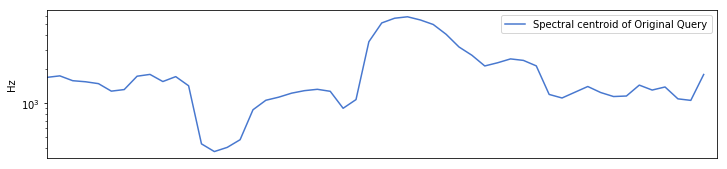

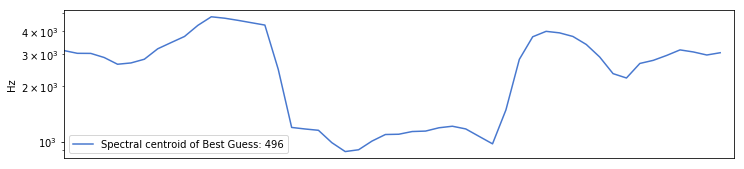

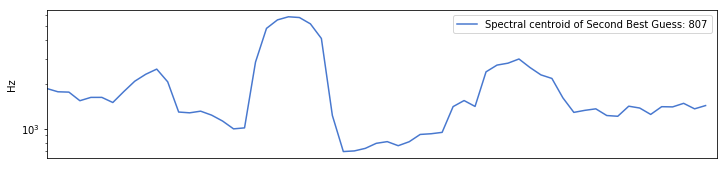

Guesses: 496 : 0.0017807619050997925
807 : 0.0020329281907696117
669 : 0.0026169622485345823
401 : 0.0026428478345625894
400 : 0.0029850004102784933
Original query: eng-8d9a16ca.flac


Best guess: 75


Second best guess: 550


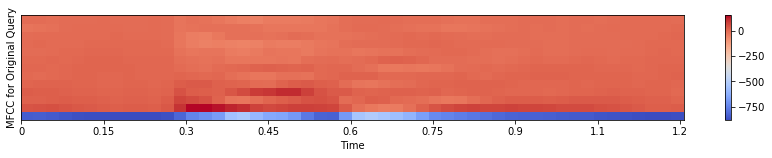

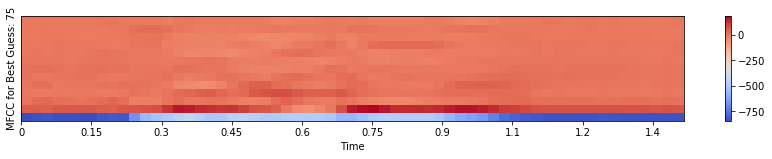

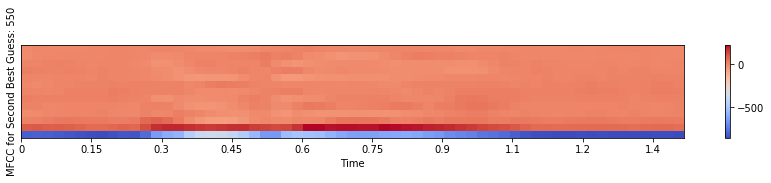

Guesses: 75 : 0.0014106333168512064
550 : 0.002129441927079534
768 : 0.0022404894445214873
294 : 0.0024110282648425185
254 : 0.0024188925716390752
Original query: eng-8d9a16ca.flac


Best guess: 746


Second best guess: 881


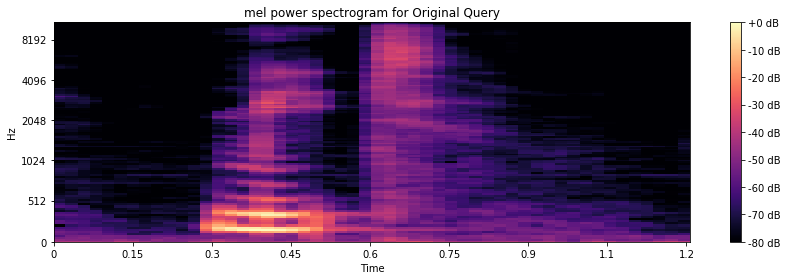

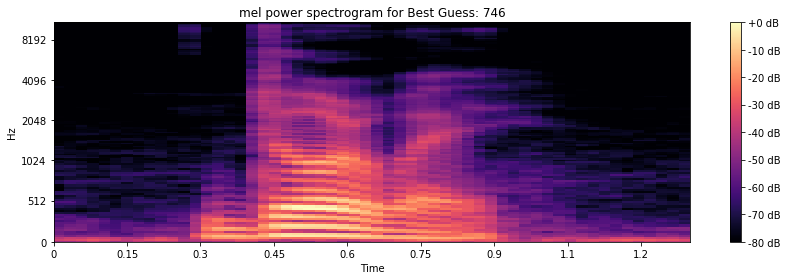

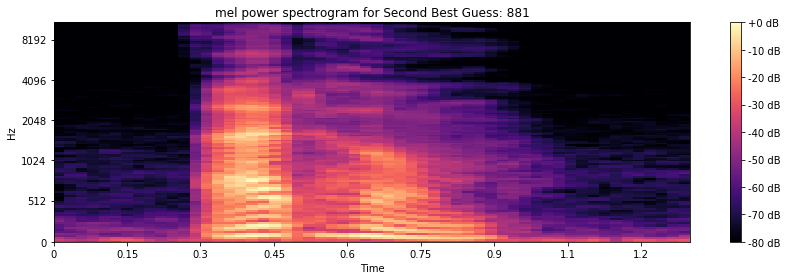

Guesses: 746 : 0.004723531053480112
881 : 0.0049730381068471274
725 : 0.005161869900686122
550 : 0.005212501295389416
702 : 0.005279693122663853


Original Query: 



Best guesses: 
Sound #75 : 0.014725139272942611


Sound #550 : 9.00734194322247


Sound #768 : 9.008039248590155


Sound #951 : 9.008793280391227


In [5]:
## Query

# Choose random sound in directory
os.chdir("/Volumes/External Storage/Thesis/Corpus/eng-balm-judith/flac")  #("/Users/aaronkarp/Documents/Thesis/testSounds")
files = []
files.extend(glob.glob("*.wav"))
files.extend(glob.glob("*.flac"))
to_check = random.choice(files)

cum_distances = [0]*num_files  # The combined distance measures

guesses, distances = query_sound(to_check, centroid_engines, num_files, sounds, samplerates, 
                                 display=True, match_type='centroid')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]
      
guesses, distances = query_sound(to_check, mfcc_engines, num_files, sounds, samplerates, 
                                 display=True, match_type='mfcc')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]

guesses, distances = query_sound(to_check, spec_engines, num_files, sounds, samplerates, 
                                 display=True, match_type='spectrogram')
print("Guesses: ", end='')
for x in guesses[:5]:
    print(str(x) + " : " + str(distances[x]))
cum_distances = [sum(x) for x in zip(distances, cum_distances)]

cum_guesses = sorted(range(len(cum_distances)), key=lambda k : cum_distances[k])

print("\n\nOriginal Query: ")
y,sr = librosa.load(to_check)
ipd.display(ipd.Audio(y, rate=sr)) # load matched file
print("\nBest guesses: ")
for i in range(0, 4):
    print("Sound #" + str(cum_guesses[i]) + " : " + str(cum_distances[cum_guesses[i]]))
    ipd.display(ipd.Audio(sounds[cum_guesses[i]], rate = samplerates[cum_guesses[i]])) # load matched file